In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
#tf.keras.mixed_precision.set_global_policy('mixed_float16')
from tqdm import tqdm

# Constants
CITYSCAPES_DIR = os.path.abspath("../data")
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
LIMIT_IMAGES = 1000
LABEL_ID = 7
BATCH_SIZE = 16
TARGET_SIZE = 256
TARGET_HEIGHT = 128

def get_image_label_pairs(images_dir, labels_dir):
    """Retrieve image and label paths."""
    image_label_pairs = []
    for city in os.listdir(images_dir):
        city_folder = os.path.join(images_dir, city)
        label_folder = os.path.join(labels_dir, city)

        # Check if the city folder is indeed a directory
        if not os.path.isdir(city_folder) or not os.path.isdir(label_folder):
            continue

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((os.path.join(city_folder, image_file), label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:
                        return image_label_pairs
    return image_label_pairs

def image_label_generator(image_label_pairs, target_size=(TARGET_HEIGHT, TARGET_SIZE), label_id=LABEL_ID, batch_size=BATCH_SIZE):
    """Generator that yields batches of images and labels."""
    while True:
        X_batch, y_batch = [], []
        for image_path, label_path in tqdm(image_label_pairs):
            image = cv2.imread(image_path)
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

            # Resize images
            X_batch.append(cv2.resize(image, (TARGET_SIZE, TARGET_HEIGHT)))
            y_batch.append((cv2.resize(label, (TARGET_SIZE, TARGET_HEIGHT)) == label_id).astype(np.uint8))

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch, y_batch = [], []

def build_unet_old(input_shape):
    """Build U-Net model."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(8, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip1 = x
    x = layers.MaxPooling2D(2)(x)

    x = layers.SeparableConv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip2 = x
    x = layers.MaxPooling2D(2)(x)

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip2])

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip1])

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
)

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    x = Conv2D(filters, kernel_size, activation=activation, padding='same')(inputs)
    x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)
    return x

def build_unet(input_shape=(128, 128, 3), num_classes=1, filters=64):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, filters)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, filters * 8)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, filters * 16)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, filters * 8)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, filters * 4)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, filters * 2)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, filters)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def train_model(train_generator, val_generator, steps_per_epoch , validation_steps, epochs=20):
    """Train the U-Net model using the provided generators."""
    input_shape = (TARGET_HEIGHT, TARGET_SIZE, 3)
    model = build_unet(input_shape)
    model.summary()

    # Callbacks for model checkpointing and early stopping
    checkpoint_cb = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
    early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss", mode="min")

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )
    return model, history

In [3]:
# Example usage
EPOCHS = 10
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10

# Prepare image-label pairs and create generators
image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
train_generator = image_label_generator(image_label_pairs)
val_generator = image_label_generator(image_label_pairs)  # Replace with actual validation pairs


In [4]:

'''# Train the model
model, history = train_model(train_generator, val_generator, STEPS_PER_EPOCH, VALIDATION_STEPS, EPOCHS)

# Summarize the model
model.summary()
model.save("unet_model.keras")'''

'# Train the model\nmodel, history = train_model(train_generator, val_generator, STEPS_PER_EPOCH, VALIDATION_STEPS, EPOCHS)\n\n# Summarize the model\nmodel.summary()\nmodel.save("unet_model.keras")'

In [5]:
model = models.load_model("unet_model.keras")

  2%|▏         | 15/1000 [00:00<00:37, 26.46it/s]

1/1 [==============================] - 6s 6s/step


  3%|▎         | 30/1000 [00:07<03:08,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 45/1000 [00:08<01:04, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 63/1000 [00:09<00:42, 22.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 78/1000 [00:09<00:41, 22.46it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 93/1000 [00:10<00:40, 22.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 111/1000 [00:11<00:38, 23.16it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 111/1000 [00:11<01:34,  9.45it/s]


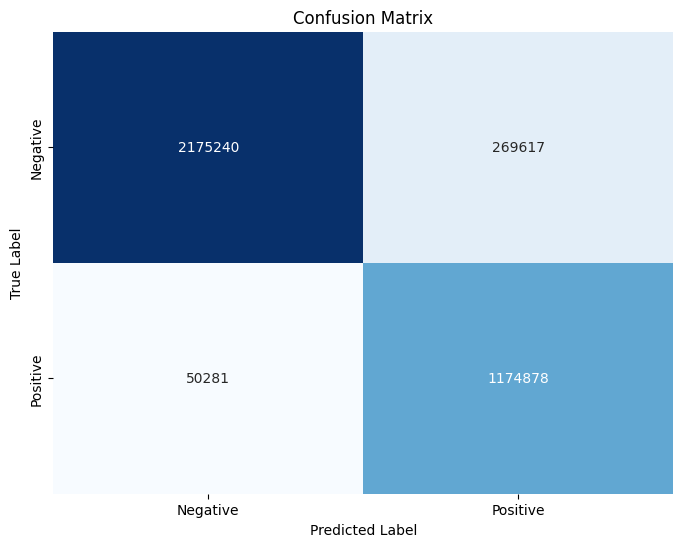

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.89      0.93   2444857
    Positive       0.81      0.96      0.88   1225159

    accuracy                           0.91   3670016
   macro avg       0.90      0.92      0.91   3670016
weighted avg       0.92      0.91      0.91   3670016



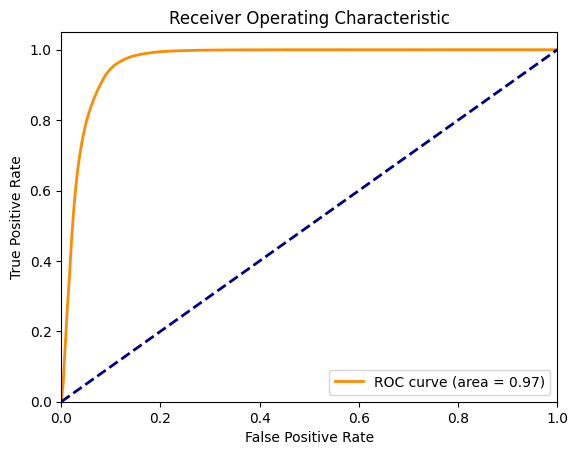

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

y_true = []
y_pred = []

# Evaluate the model on a predefined number of images
num_images_to_evaluate = 100  # Set this to the number of images you want to evaluate
count = 0

for X, y in image_label_generator(image_label_pairs):
    y_true.extend(y.flatten())
    y_pred.extend(model.predict(X).flatten())
    count += len(y)  # Assuming y is a batch of labels
    if count >= num_images_to_evaluate:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred > 0.5, target_names=['Negative', 'Positive']))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

  2%|▏         | 24/1000 [00:01<00:47, 20.45it/s]

 1/10 [==>...........................] - ETA: 4s - loss: 0.1855 - accuracy: 0.9243

  3%|▎         | 33/1000 [00:01<00:42, 22.67it/s]

 2/10 [=====>........................] - ETA: 3s - loss: 0.3040 - accuracy: 0.8816

  5%|▍         | 48/1000 [00:02<00:38, 24.60it/s]

 3/10 [========>.....................] - ETA: 3s - loss: 0.2655 - accuracy: 0.8953

  7%|▋         | 66/1000 [00:02<00:36, 25.87it/s]

 4/10 [===========>..................] - ETA: 3s - loss: 0.2416 - accuracy: 0.9055

  8%|▊         | 81/1000 [00:03<00:35, 26.11it/s]

 5/10 [==============>...............] - ETA: 2s - loss: 0.2222 - accuracy: 0.9148

 10%|▉         | 96/1000 [00:03<00:35, 25.32it/s]

 6/10 [=================>............] - ETA: 2s - loss: 0.2206 - accuracy: 0.9135

 11%|█▏        | 114/1000 [00:04<00:35, 24.90it/s]

 7/10 [====================>.........] - ETA: 1s - loss: 0.2196 - accuracy: 0.9128

 13%|█▎        | 129/1000 [00:05<00:33, 25.74it/s]

 8/10 [=======================>......] - ETA: 1s - loss: 0.2165 - accuracy: 0.9139

 14%|█▍        | 144/1000 [00:05<00:33, 25.63it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.2137 - accuracy: 0.9144

 16%|█▌        | 162/1000 [00:06<00:33, 25.15it/s]

10/10 [==============================] - 6s 604ms/step - loss: 0.2102 - accuracy: 0.9159


 19%|█▉        | 189/1000 [00:07<00:32, 24.89it/s]

1/1 [==============================] - 0s 18ms/step
(16, 128, 256, 1)


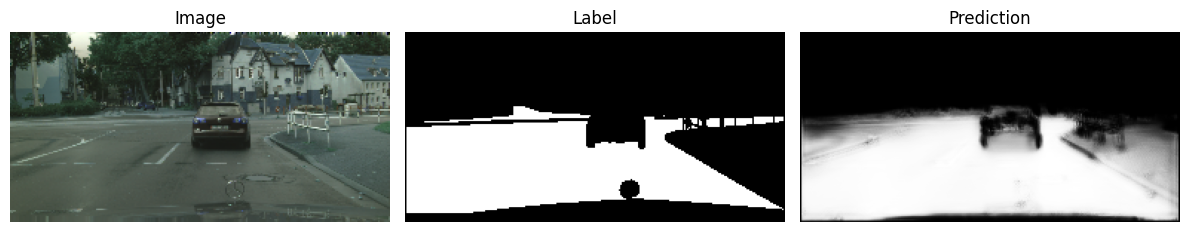

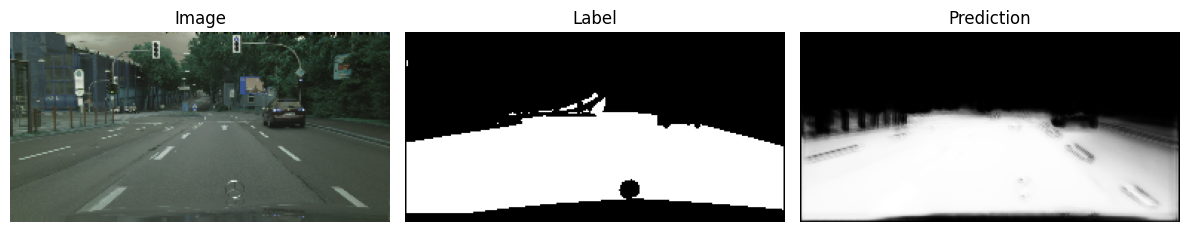

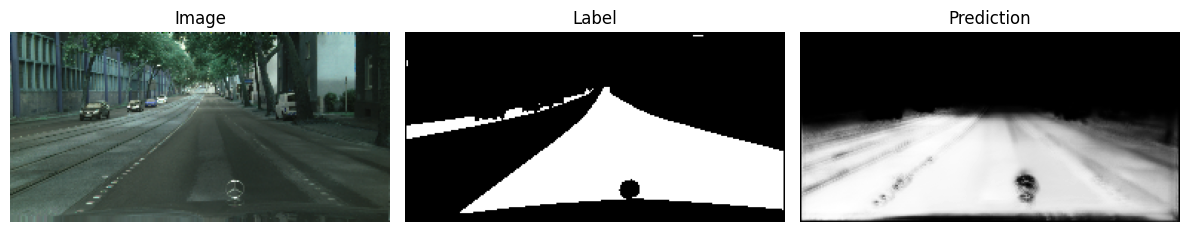

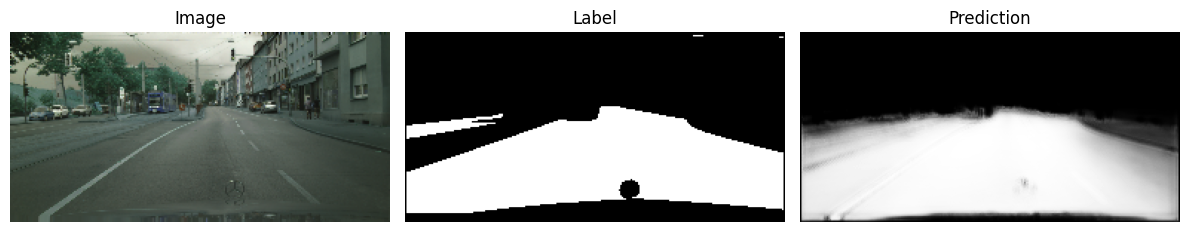

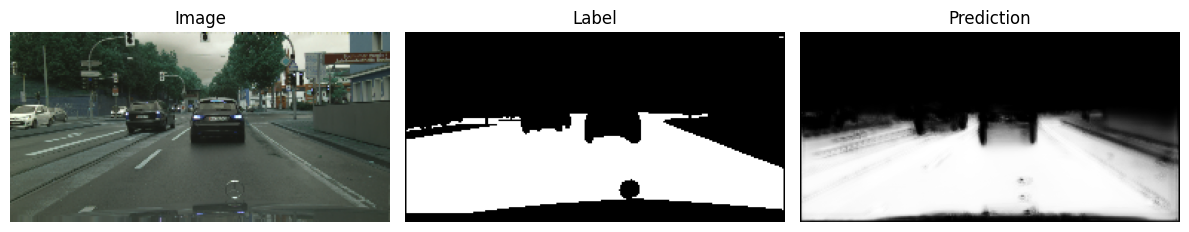

In [7]:
# evaluate the model
model.evaluate(val_generator, steps=10)

# Predict on a batch of images
X_batch, y_batch = next(val_generator)
y_pred = model.predict(X_batch)
print(y_pred.shape)  # (32, 128, 256, 1)

# Visualize the predictions with the original images and labels in the same plot row by row
import matplotlib.pyplot as plt
for i in range(5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_batch[i])
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(y_batch[i].squeeze(), cmap="gray")
    axes[1].set_title("Label")
    axes[1].axis("off")
    axes[2].imshow(y_pred[i].squeeze(), cmap="gray")
    axes[2].set_title("Prediction")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

(128, 256, 3)
(128, 256, 3)
(128, 256, 3)
(128, 256, 3)
(128, 256, 3)
1/1 [==============================] - 2s 2s/step


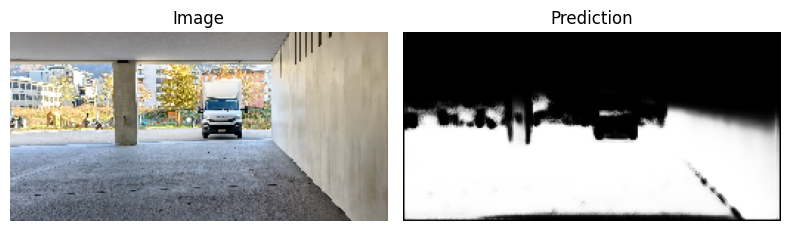

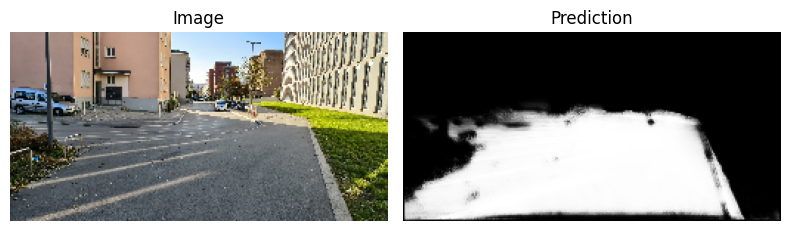

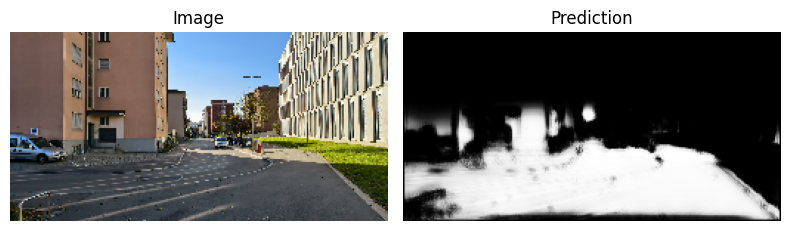

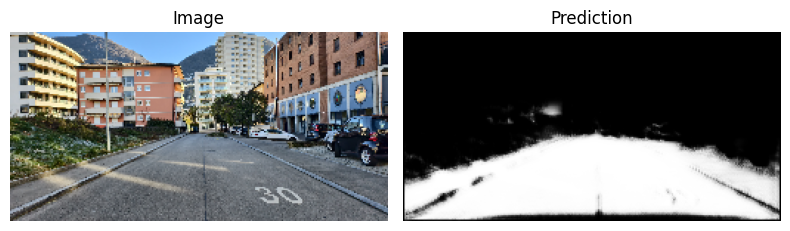

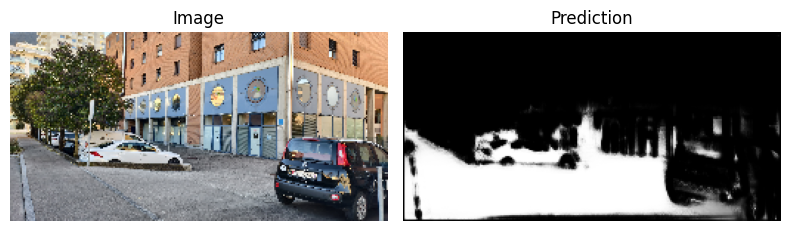

In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras import models
import matplotlib.pyplot as plt

# Load and preprocess the images
personal_images = []
target_w = 256
target_h = target_w // 2
image_folder = os.path.join('..', 'data', 'personal_images')
for image_name in os.listdir(image_folder)[:5]:
    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)
        original = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Convert the original image to RGB
        image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Resize the image keeping aspect ratio and cropping excess
        h, w, _ = image.shape
        scale = max(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h))
        
        # Crop the excess area to get the final dimensions
        left = (new_w - target_w) // 2
        top = (new_h - target_h) // 2
        image = resized_image[top:top + target_h, left:left + target_w]

        print(image.shape)
        
        # Append the processed image to the list
        personal_images.append(image)

personal_images = np.array(personal_images)

# Predict on the images
predictions = model.predict(personal_images)

# Visualize the predictions
for i in range(len(personal_images)):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(personal_images[i])
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(predictions[i].squeeze(), cmap="gray")
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

In [21]:
import cv2
import numpy as np
from tensorflow.keras import models
from IPython.display import display, clear_output
from PIL import Image
import io

# Load the model
model = models.load_model("unet_model.keras")

# Open the video file
video_path = "../data/personal_video/video.mp4"
video = cv2.VideoCapture(video_path)

# Get the video properties
fps = 2
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to save the output video
output_path = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_path, fourcc, 60, (width, height * 3))

# Define target dimensions for resizing
target_w, target_h = 256, 128

frame_count = 0
while True:
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % fps != 0:
        continue

    # Preprocess the frame
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    scale = max(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    left = (new_w - target_w) // 2
    top = (new_h - target_h) // 2
    image = resized_image[top:top + target_h, left:left + target_w]

    # Predict on the frame
    prediction = model.predict(np.expand_dims(image, axis=0))[0]

    # Ensure the mask is of type uint8
    mask = (prediction > 0.5).astype(np.uint8) * 255

    # Ensure the mask has the same size as the frame
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

    # Apply the mask to the frame
    result = cv2.bitwise_and(frame, frame, mask=mask)

    # Convert prediction to grayscale
    prediction_gray = cv2.resize(prediction.squeeze(), (frame.shape[1], frame.shape[0]))
    prediction_gray = (prediction_gray * 255).astype(np.uint8)

    # Combine the frame, the result, and the prediction horizontally
    output_frame = np.vstack([frame, result, cv2.cvtColor(prediction_gray, cv2.COLOR_GRAY2BGR)])

    # Write the frame to the output video
    output.write(output_frame)

    '''# Display the frame in the notebook
    _, buffer = cv2.imencode('.png', output_frame)
    frame_image = Image.open(io.BytesIO(buffer))
    clear_output(wait=True)  # Clear previous output to simulate real-time processing
    display(frame_image)'''

# Release resources
video.release()
output.release()


1/1 [==============================] - 0s 17ms/step
